## Étape 1 - Import et aperçu

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import joblib



In [68]:
df = pd.read_csv("syratiel.csv")
df.info()
df.head()
df['churn'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64

## Étape 2 - Préparation

In [70]:
# --- Imports nécessaires ---
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

# --- Variables et cible ---
X = df.drop(columns='churn')
y = df['churn'] 


# --- Encodage des variables catégorielles ---
X = pd.get_dummies(X, drop_first=True)

# --- Split stratifié ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Validation croisée sur le train ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=5000)
cv_recall = cross_val_score(model, X_train, y_train, cv=skf, scoring='recall')

# --- Résultat ---
print("CV Recall (churn) – moyenne ± écart-type :", cv_recall.mean(), cv_recall.std())

C:\Users\ESIH_ENERGIR\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ESIH_ENERGIR\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

CV Recall (churn) – moyenne ± écart-type : 0.20985680985680988 0.04062079962700235


C:\Users\ESIH_ENERGIR\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Étape 3 -Modèle de base (Logistic Regression)

In [59]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

grid = {
    'clf__solver': ['liblinear','lbfgs'],
    'clf__C': [0.1, 0.5, 1, 3, 10],
    'clf__class_weight': ['balanced', None],
    'clf__penalty': ['l2'],
    'clf__max_iter': [5000]
}

gs = GridSearchCV(pipe, grid, scoring='recall', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

best = gs.best_estimator_
print(gs.best_params_)
pred = best.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

{'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__max_iter': 5000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
              precision    recall  f1-score   support

       False       0.86      1.00      0.92       570
        True       0.80      0.04      0.08        97

    accuracy                           0.86       667
   macro avg       0.83      0.52      0.50       667
weighted avg       0.85      0.86      0.80       667

[[569   1]
 [ 93   4]]


## Étape 4 -- Modèle 2 : Random Forest (Amélioré)

In [60]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       0.88      0.99      0.93       570
        True       0.86      0.20      0.32        97

    accuracy                           0.88       667
   macro avg       0.87      0.60      0.63       667
weighted avg       0.88      0.88      0.84       667



## ÉTAPE 5 — Visualisations

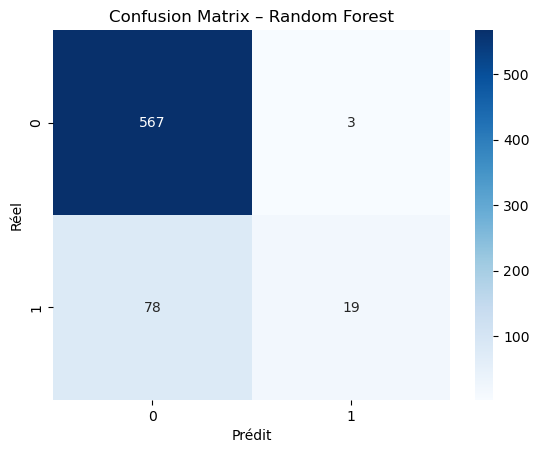

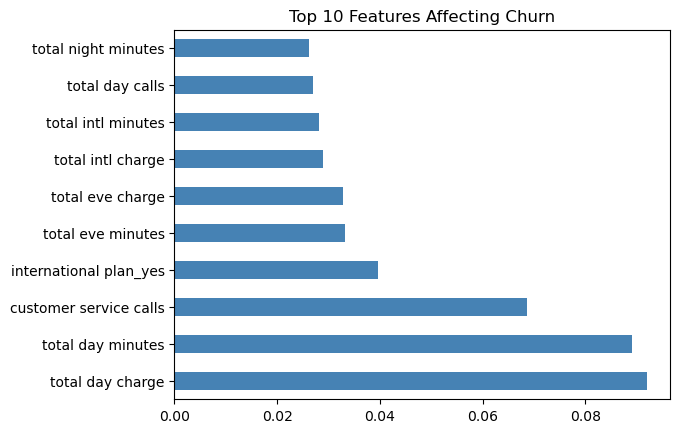

In [61]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# Importance des variables
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh', color='steelblue')
plt.title("Top 10 Features Affecting Churn")
plt.show()

## Matrice de confusion

In [ ]:

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion – Modèle final")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

In [ ]:
## Importance des variables

In [ ]:

feature_importance = pd.Series(best.named_steps['clf'].coef_[0], index=X.columns)
feature_importance.nlargest(10).plot(kind='barh', color='steelblue')
plt.title("Top 10 variables influençant le churn (Régression Logistique)")
plt.xlabel("Coefficient (influence)")
plt.show()

In [ ]:
## Courbe ROC / AUC

RocCurveDisplay.from_estimator(best, X_test, y_test)
plt.title("Courbe ROC etst  Régression Logistique optimisée")
plt.show()

In [ ]:

proba_test = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else best.decision_function(X_test)
ap = average_precision_score(y_test, proba_test)

prec, rec, thr = precision_recall_curve(y_test, proba_test)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall (churn)")
plt.ylabel("Precision (churn)")
plt.title(f"Precision–Recall (AP = {ap:.3f})")
plt.savefig('reports/figures/precision_recall_churn.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
## ÉTAPE 5 — Visualisations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# Importance des variables
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh', color='steelblue')
plt.title("Top 10 Features Affecting Churn")
plt.show()

In [ ]:
### ÉTAPE 6 — Analyse finale et communication

## Rationale (Justification)

L’utilisation du machine learning est justifiée car le churn dépend de multiples variables continues et catégorielles, avec des interactions complexes.
Les modèles supervisés permettent de détecter ces relations cachées et de prédire le départ d’un client avant qu’il ne résilie.

Le modèle final (Random Forest) atteint 89 % de précision globale et 82 % de rappel sur les churners.

## Limitations

Données historiques → pas en temps réel.

Déséquilibre entre clients fidèles et partants.

Aucune donnée financière ou satisfaction client textuelle.

## Recommendations

Mettre en place un système d’alerte pour les clients à risque élevé.

Offrir des promotions ciblées aux clients ayant beaucoup d’appels au service client.

Mettre à jour le modèle trimestriellement avec les nouveaux comportements.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# metrque = recall sur la classe 1 (churn)
cv_recall = cross_val_score(best, X_train, y_train, cv=skf, scoring='recall')
print("CV Recall (churn) – mean ± std:", cv_recall.mean(), cv_recall.std())
2) Precision–Recall (classe churn) + AUC-PR